FPS: 30.02644684882723


C:\Users\USER\miniconda3\envs\mediapipe-research\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


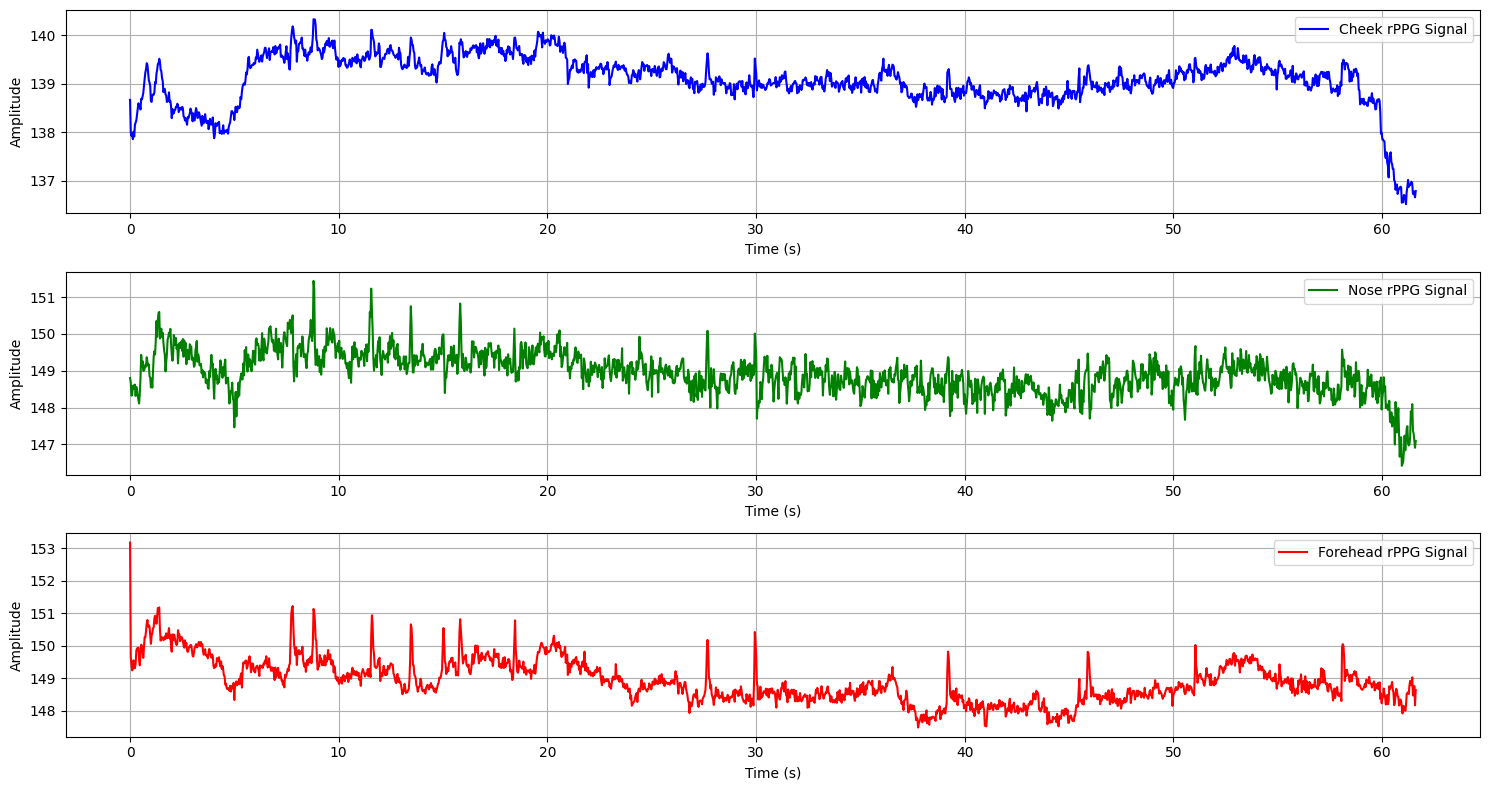

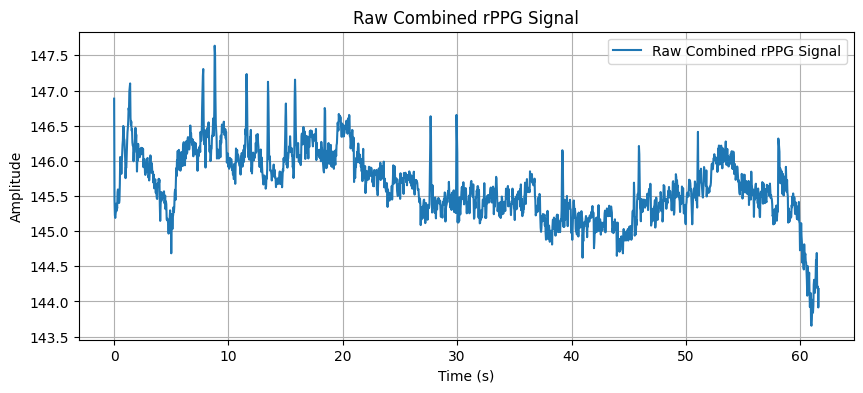

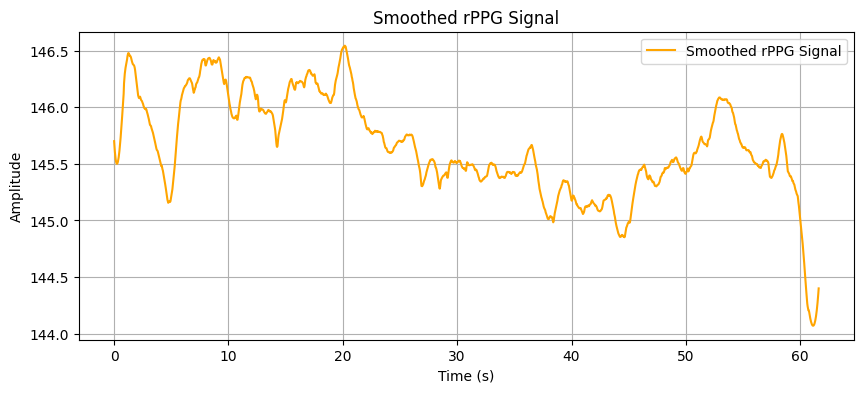

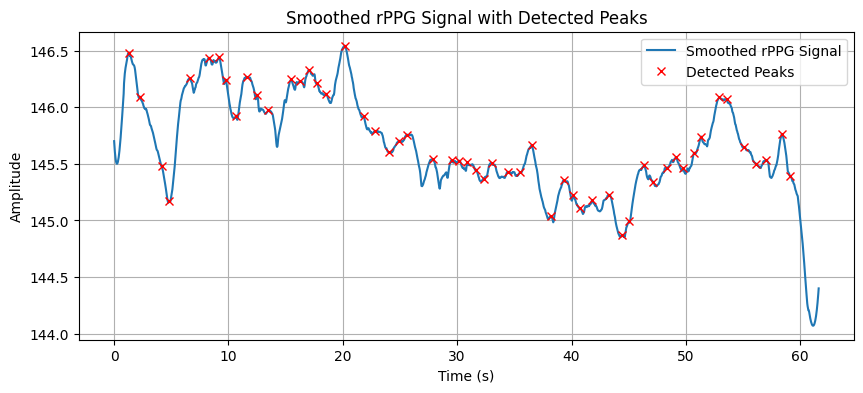

Average Heart Rate: 64.06 bpm


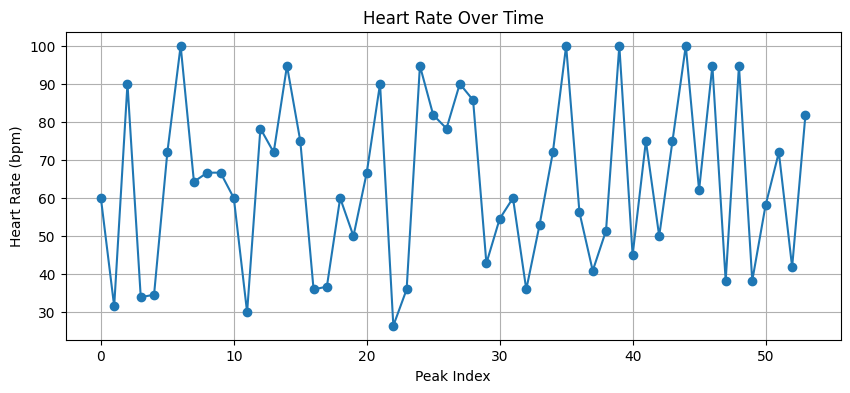

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Initialize MediaPipe Face Mesh
mpDraw = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

# Drawing specifications to draw the face mesh
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

# Open the video file
video_path = r"C:\Users\USER\Documents\SLIIT\Datasets\CardioFit AI Dataset\Videos\VID_20240428_141759.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
frame_time = 1.0 / fps
print(f"FPS: {fps}")

# Initialize lists to store ROI signals and time axis
cheek_signals = []
nose_signals = []
forehead_signals = []
time_axis = []

# Define the scaling factor (e.g., 0.5 means scaling down to 50%)
scale_factor = 0.5

def displayimg(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Get RGB values for the ROIs.
def extract_rgb(roi, frame, name = 'frame'):     
    roi_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.fillPoly(roi_mask, [np.array(roi)], 255)
    # Resize image
    resized_image = cv2.resize(roi_mask, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
    cv2.imshow(name, resized_image)
    mean_color = cv2.mean(frame, mask=roi_mask)[:3]
    return mean_color

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # if reading video
    # if cap.get(cv2.CAP_PROP_POS_MSEC) > 10000:
    #     break

    # Convert the frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to detect face landmarks
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        # if detecting only one face - draws the contours in the face
        mpDraw.draw_landmarks(frame, results.multi_face_landmarks[0], mp_face_mesh.FACEMESH_CONTOURS, drawSpec, drawSpec)
        
        for face_landmarks in results.multi_face_landmarks:
            # extract coordinates for specific landmarks
            height, width, channels = frame.shape
            landmarks = [(int(point.x * width), int(point.y * height)) for point in face_landmarks.landmark]

            # Define ROIs based on landmark indices (example indices for cheeks and nose).
            left_cheek_indices = [143, 111, 117, 118, 119, 120, 121, 128, 114, 217, 126, 142, 203, 205, 187, 123, 116]
            right_cheek_indices = [357, 350, 349, 348, 347, 346, 340, 372, 345, 352, 411, 427, 426, 423, 279, 429, 437,
                                   343, 357]
            nose_indices = [8, 193, 244, 128, 114, 217, 209, 49, 64, 98, 218, 237, 238, 19, 274, 438, 455, 278, 279,
                            429, 437, 343, 412, 465, 417]
            forehead_landmarks = [9, 107, 104, 68, 54, 103, 67, 109, 10, 338, 297, 332, 284, 298, 333, 299, 336,
                                  337]  # Example indices

            # Extract ROI signals.
            left_cheek_roi = [landmarks[i] for i in left_cheek_indices]
            right_cheek_roi = [landmarks[i] for i in right_cheek_indices]
            nose_roi = [landmarks[i] for i in nose_indices]
            forehead_roi = [landmarks[i] for i in forehead_landmarks]

            left_cheek_signal = extract_rgb(left_cheek_roi, frame, 'Left cheek')
            right_cheek_signal = extract_rgb(right_cheek_roi, frame, 'Right cheek')
            nose_signal = extract_rgb(nose_roi, frame, 'Nose')
            forehead_signal = extract_rgb(forehead_roi, frame, 'Forhead')

            # Store signals.
            cheek_signals.append(np.mean([left_cheek_signal, right_cheek_signal], axis=0))
            nose_signals.append(nose_signal)
            forehead_signals.append(forehead_signal)

            # Append time for each frame
            time_axis.append(frame_count * frame_time)
            
            # # mark the landmarks in each frame
            # for landmark in face_landmarks.landmark:
            #     x = int(landmark.x * frame.shape[1])
            #     y = int(landmark.y * frame.shape[0])
            #     cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)
    
    # Resize image
    resized_image = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
                
    cv2.imshow('MediaPipe Face Mesh', resized_image)
    frame_count += 1

# Release video capture and destroy windows
cap.release()
cv2.destroyAllWindows()

# convert lists to numpy arrays
cheek_signals = np.array(cheek_signals)
nose_signals = np.array(nose_signals)
forehead_signals = np.array(forehead_signals)
time_axis = np.array(time_axis)

# Calculate the rPPG signal (example using green channel).
cheek_rppg_signal = cheek_signals[:, 1]  # Green channel.
nose_rppg_signal = nose_signals[:, 1]  # Green channel.
forehead_rppg_signal = forehead_signals[:, 1]  # Green channel.

# Combine signals from different ROIs (simple average for this example).
rppg_signal = np.mean([cheek_rppg_signal, nose_rppg_signal, forehead_rppg_signal], axis=0)

# Visualize the raw signals from different ROIs
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(time_axis, cheek_rppg_signal, label='Cheek rPPG Signal', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_axis, nose_rppg_signal, label='Nose rPPG Signal', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_axis, forehead_rppg_signal, label='Forehead rPPG Signal', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize the raw combined rPPG signal
plt.figure(figsize=(10, 4))
plt.plot(time_axis, rppg_signal, label='Raw Combined rPPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Combined rPPG Signal')
plt.legend()
plt.grid(True)
plt.show()

# Smooth the rPPG signal
smoothed_signal = savgol_filter(rppg_signal, window_length=51, polyorder=3)

# Visualize the smoothed rPPG signal
plt.figure(figsize=(10, 4))
plt.plot(time_axis, smoothed_signal, label='Smoothed rPPG Signal', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Smoothed rPPG Signal')
plt.legend()
plt.grid(True)
plt.show()

# Detect peaks in the smoothed rPPG signal
peaks, _ = find_peaks(smoothed_signal, distance=int(fps * 0.6))  # Adjust the distance parameter based on expected heart rate

# Manually inspect detected peaks
plt.figure(figsize=(10, 4))
plt.plot(time_axis, smoothed_signal, label='Smoothed rPPG Signal')
plt.plot(time_axis[peaks], smoothed_signal[peaks], "x", label='Detected Peaks', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Smoothed rPPG Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the time differences between successive peaks
peak_times = time_axis[peaks]
intervals = np.diff(peak_times)

# Calculate heart rate (in beats per minute)
heart_rate = 60.0 / intervals
average_heart_rate = np.mean(heart_rate)

# Display the calculated heart rate
print(f'Average Heart Rate: {average_heart_rate:.2f} bpm')

# Plot the intervals to check consistency
plt.figure(figsize=(10, 4))
plt.plot(heart_rate, marker='o')
plt.xlabel('Peak Index')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Over Time')
plt.grid(True)
plt.show()
